In [1]:
# Добавляем нужные библиотеки
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sklearn
import xgboost as xgb
from sklearn.metrics import f1_score, roc_auc_score,ndcg_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


2024-04-10 01:01:33.278916: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-10 01:01:33.280305: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 01:01:33.302040: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 01:01:33.302065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 01:01:33.302674: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# загружаем таблицы данных
members_pd = pd.read_csv("members.csv")
songs_pd = pd.read_csv('songs.csv')
sample_pd = pd.read_csv("sample_submission.csv")
tranin_data_pd = pd.read_csv('train.csv')
tranin_data_pd.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1.0


In [3]:
#Соеденяем все таблицы в одну
merge_df = pd.merge(tranin_data_pd, members_pd, on="msno", how='inner')
train_df = pd.merge(merge_df, songs_pd, on="song_id", how='inner')

In [4]:
# выделяем числовые данные и категориальные данные
categorical_features = train_df.select_dtypes(include='O').columns
numeric_features = train_df.select_dtypes(include=(np.number)).columns

#Заполняем пробелы в датасете
for col in categorical_features:
    train_df[col] = train_df[col].fillna('UnKnown')
for col in numeric_features:
    train_df[col] = train_df[col].interpolate(method='linear')

In [5]:
# Разбиваем датасет на фичи и таргетные значения
Y_data = train_df["target"]
X_data = train_df.drop(columns="target",axis= 1)
X_processed = X_data.copy()

# Применяем Label Encoding к каждому категориальному признаку, чтоб перевести его в числовой
# Автоматически алгоритмы из sklearn с этим не справляются
label_encoder = LabelEncoder()
for feature in categorical_features:
    X_processed[feature] = label_encoder.fit_transform(X_data[feature])
    
X_processed.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language
0,6739,56536,2,7,6,1,0,0,7,20120102,20171005,206471,261,2588,11452,16977,52.0
1,21450,56536,1,11,6,15,18,2,4,20151220,20170930,206471,261,2588,11452,16977,52.0
2,24540,56536,4,8,4,1,0,0,7,20120804,20171004,206471,261,2588,11452,16977,52.0
3,22369,56536,4,8,4,5,21,1,9,20110808,20170917,206471,261,2588,11452,16977,52.0
4,13434,56536,4,8,4,6,33,1,9,20070323,20170915,206471,261,2588,11452,16977,52.0


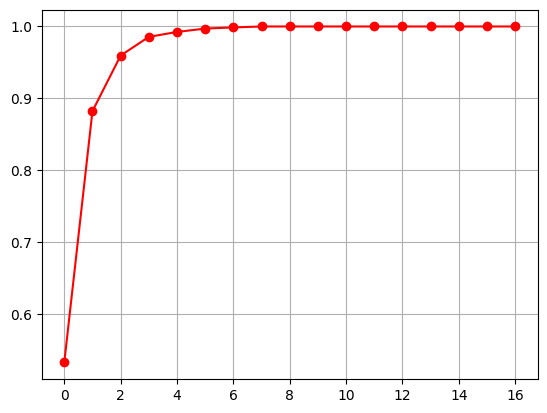

In [6]:
# Теперь, когда мы привели все данные к числовым значениям, можем воспользоваться методом главных компонент
# Это позволит снизить размерность обучающей выборки, и ускорить обучение
X_data = np.array(X_processed)
Y_data = np.array(Y_data)
pca = PCA()
x_pca = pca.fit_transform(X_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.grid()
plt.show()

Видно, что достаточно 4х компонент

In [7]:
pca_new = PCA(n_components=4)
x_new = pca_new.fit_transform(X_data)
x_train, x_test, y_train, y_test = train_test_split(x_new, Y_data, train_size=0.7)

In [8]:
# Попробуем использовать Градиентный бустинг. Он довольно хорошо справляется с данными, в которых много пробелов
# Так же он подходит для бинарной классификации, что в целом можно сказать про все алгоритмы ниже
clf = sklearn.ensemble.GradientBoostingClassifier()
clf.fit(x_train, y_train)

GradientBoostingClassifier()

In [9]:
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

ndcg = sklearn.metrics.ndcg_score([y_train_pred], [y_train], k= 20)
print("Train NDCG@k -score:", ndcg)
ndcg = sklearn.metrics.ndcg_score([y_test_pred], [y_test], k= 20)
print("Test NDCG@k -score:", ndcg)


Train NDCG@k -score: 0.9318433659630282
Test NDCG@k -score: 0.9314638362883447


In [10]:
#Попробуем еще радномный лес. Он тоже должен хорошо рабоать с пробелами в данных.
rf = sklearn.ensemble.RandomForestClassifier(max_depth=16, random_state=0) #Если сделать максимальную глубину дерева больше, оно начнет переобучаться
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=16, random_state=0)

In [11]:
y_train_pred = rf.predict(x_train)
y_test_pred = rf.predict(x_test)

ndcg = sklearn.metrics.ndcg_score([y_train_pred], [y_train], k= 20)
print("Train NDCG@k -score:", ndcg)
ndcg = sklearn.metrics.ndcg_score([y_test_pred], [y_test], k= 20)
print("Test NDCG@k -score:", ndcg)


Train NDCG@k -score: 0.9342562344415697
Test NDCG@k -score: 0.9085983462656962


In [12]:
#Попоробуем логистическую регрессию
lr = sklearn.linear_model.LogisticRegression(max_iter=300,C=0.001,penalty="l2")
lr.fit(x_train,y_train)

LogisticRegression(C=0.001, max_iter=300)

In [13]:
y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

ndcg = sklearn.metrics.ndcg_score([y_train_pred], [y_train], k= 20)
print("Train NDCG@k -score:", ndcg)
ndcg = sklearn.metrics.ndcg_score([y_test_pred], [y_test], k= 20)
print("Test NDCG@k -score:", ndcg)

Train NDCG@k -score: 0.5559856216960348
Test NDCG@k -score: 0.5563006740910491


In [14]:
#XGBoost
xg = xgb.XGBClassifier()
xg.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [15]:
y_train_pred = xg.predict(x_train)
y_test_pred = xg.predict(x_test)

ndcg = sklearn.metrics.ndcg_score([y_train_pred], [y_train], k= 20)
print("Train NDCG@k -score:", ndcg)
ndcg = sklearn.metrics.ndcg_score([y_test_pred], [y_test], k= 20)
print("Test NDCG@k -score:", ndcg)

Train NDCG@k -score: 0.861894906811868
Test NDCG@k -score: 0.8577145231107358


Лучшим является алгоритм градиентного бустинга


Используем алгоритм Градиентного бустинга на тестовых данных

In [16]:
test_data = pd.read_csv('test.csv')
test_data.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [17]:

merge_df = pd.merge(test_data, members_pd, on="msno", how='inner')
test_df = pd.merge(merge_df, songs_pd, on="song_id", how='inner')
test_df.head()



,id,msno,song_id,source_system_tab,source_screen_name,source_type,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,1,0,NaN,7,20160219,20170918,224130,458,梁文音 (Rachel Liang),Qi Zheng Zhang,NaN,3.0
1,1035059,08rvvaaab7dM7h78GC4SphLkUCSXPxpu6sY+k8aLUO4=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,5,29,female,7,20120105,20171113,224130,458,梁文音 (Rachel Liang),Qi Zheng Zhang,NaN,3.0
2,89968,1NvrMNDUcvfqOIjhim8BgdK23znMzGwAO84W+qKs6dw=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,14,20,NaN,3,20130908,20171003,224130,458,梁文音 (Rachel Liang),Qi Zheng Zhang,NaN,3.0
3,972394,GfSXhTVP3oj7h0545L/5xh6jD+7edQ7AH0iprl7dYbc=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,22,22,male,7,20131011,20170911,224130,458,梁文音 (Rachel Liang),Qi Zheng Zhang,NaN,3.0
4,2194574,HkWEvfQyrb5Lve8X3B7HkCEkDFW8qFy/9kWFb4QbM5k=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,discover,Discover Feature,song-based-playlist,15,26,female,9,20060616,20180516,224130,458,梁文音 (Rachel Liang),Qi Zheng Zhang,NaN,3.0


In [18]:
id_column = test_df["id"]
test_df = test_df.drop(columns="id",axis= 1)
categorical_features = test_df.select_dtypes(include='O').columns
numeric_features = test_df.select_dtypes(include=(np.number)).columns
for col in categorical_features:
    test_df[col] = test_df[col].fillna('UnKnown')
for col in numeric_features:
    test_df[col] = test_df[col].interpolate(method='linear')
    
X_test_processed = test_df.copy()

for feature in categorical_features:
    X_test_processed[feature] = label_encoder.fit_transform(test_df[feature])
    
X_test_processed.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language
0,12934,122182,4,8,4,1,0,0,7,20160219,20170918,224130,300,24889,33218,15017,3.0
1,822,122182,4,8,4,5,29,1,7,20120105,20171113,224130,300,24889,33218,15017,3.0
2,1305,122182,4,8,4,14,20,0,3,20130908,20171003,224130,300,24889,33218,15017,3.0
3,7258,122182,4,8,4,22,22,2,7,20131011,20170911,224130,300,24889,33218,15017,3.0
4,7715,122182,1,4,10,15,26,1,9,20060616,20180516,224130,300,24889,33218,15017,3.0


In [19]:
X_test_data = np.array(X_test_processed)
X_test_data_transform = pca_new.transform(X_test_data)

In [20]:
y_real_pred = clf.predict(X_test_data_transform)

In [21]:
df = pd.DataFrame({"id":id_column, 'prediction':y_real_pred }) 

df.to_csv("data.csv")